In [1]:
# Common modules/packages
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
import sys, shutil, time

# PyTorch modules/packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from PIL import ImageFile

%matplotlib inline

In [2]:
device = 'cpu'  # sets the default value
train_on_gpu = torch.cuda.is_available()  # returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4096MB, multi_processor_count=16)


In [3]:
# Retrieves the list of files with a directory
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFoldersInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

In [4]:
# DEFINE DATA DIRECTORIES & LOCATION OF IMAGE-SETS ARCHIVE
# --------------------------------------------------------

# sets the root folder for image sets
pathToDataset = pathlib.Path.cwd().joinpath('Dataset')
pathToTrain = pathToDataset.joinpath('train')
pathToTest = pathToDataset.joinpath('test')
pathToValid = pathToDataset.joinpath('valid')

# count and list art category
artCategories = getFolderNamesInDirectory(pathToTrain, ".")  # collects the list of folders

print("Total no. of categories = ", len(artCategories))
print("Categories: ", artCategories)

Total no. of categories =  4
Categories:  ['genre', 'landscape', 'portrait', 'still-life']


In [5]:
# Define the data-augmentation transforms including normalisations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# load and apply above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(pathToTrain, transform=train_transforms)
test_dataset  = datasets.ImageFolder(pathToTest , transform=test_transforms)
valid_dataset = datasets.ImageFolder(pathToValid, transform=valid_transforms)

# Print out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  1898
Testing   images:  1001
Validation images: 976


In [6]:
# Define dataloader parameters
batch_size = 16   
num_workers = 0

# Prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = False)

# Print the batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 119
Number of  testing   batches: 63
Number of validation batches: 61


In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d( 3,  8, 3, stride = 1, padding = 1)    # takes in 224*224
        self.conv2 = nn.Conv2d( 8, 24, 3, stride = 1, padding = 1)    # takes in 112*112
        self.conv3 = nn.Conv2d(24, 72, 3, stride = 1, padding = 1)    # takes in 56*56
        self.conv4 = nn.Conv2d(72, 144, 3, stride = 1, padding = 1)   # takes in 28*28
        self.conv5 = nn.Conv2d(144,288, 3, stride = 1, padding = 1)   # takes in 14*14

        self.maxpool = nn.MaxPool2d(2,2)        

        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(288*7*7, 4096) # input to fc1 is (output filters of conv. part = 64) * (dimensions of each = 14*14) 
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 14)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))  # takes 224*224
        x = self.maxpool(x)        # gives 112*112 
        x = F.relu(self.conv2(x))  # takes 112*112
        x = self.maxpool(x)        # gives 56*56
        x = F.relu(self.conv3(x))  # takes 56*56
        x = self.maxpool(x)        # gives 28*28
        x = F.relu(self.conv4(x))  # takes 28*28
        x = self.maxpool(x)        # gives 14*14
        x = F.relu(self.conv5(x))  # takes 14*14
        x = self.maxpool(x)        # gives 7*7
        
        x = x.view(-1, 288*7*7)    # flattening output of convolutional part

        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        x = self.fc3(x)            # dropout and activation function is not used on last layer
        
        return x

# instantiate the CNN
model_scratch = Net()

# move model to GPU if CUDA is available
if train_on_gpu == True:
    model_scratch.to(device)

print(model_scratch)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=14112, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=14, bias=True)
)


In [8]:
model_name = 'customised'
model_filename = 'trained_' + model_name + '.pt'
pathToModel = pathlib.Path.cwd().joinpath( 'models', model_filename)
print('File name for saved model: ', pathToModel)

File name for saved model:  C:\Users\Omkar Kadam\Desktop\Ml-Projects\Ml-Project2\models\trained_customised.pt


In [9]:
### Select loss function
criterion = nn.CrossEntropyLoss()

### Select optimizer
optimizer = optim.Adam(model_scratch.parameters(), lr = 0.001)

In [10]:
# Some images in dataset were truncated (maybe corrupted)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set number of epochs to train the model
n_epochs = 40

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf   # set initial "min" to infinity

# Initialise performances
train_losses, valid_losses, accuracies=[],[],[]
training_loss = 0.0
validation_loss = 0.0
accuracy = 0.0

In [11]:
a = time.time()  #Start-time for training

for epoch in range(1, n_epochs+1):
    c = time.time()  #Start-time for epoch
    
    ###############
    # TRAIN MODEL #
    ###############
        
    # model by default is set to train
    for batch_i, (images, labels) in enumerate(train_dataloader): #Getting one batch of training images and their corresponding true labels
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)

        # clear the previous/buffer gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_scratch.forward(images)
        
        # calculate the batch loss
        loss = criterion(outputs, labels)    #(y_hat, y)  or (our-prediction, true-label)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        training_loss += loss.item()
        
    ##################
    # VALIDATE MODEL #
    ##################      
    
    #validation loss and accuracy
    validation_loss = 0.0
    accuracy = 0.0

    model_scratch.eval() #model is put to evalution mode i.e. dropout is switched off

    with torch.no_grad():  #Turning off calculation of gradients (not required for validaiton)  {saves time}

        for images, labels in valid_dataloader:   #Getting one batch of validation images
            
            if train_on_gpu:   #moving data to GPU if available
                images = images.to(device)
                labels = labels.to(device)

            outputs = model_scratch.forward(images)

            # calculate the batch loss
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            
            # Calculating accuracy
            ps = torch.exp(outputs)   #Turning raw output values into probabilities using exponential function

            #getting top one probablilty and its corresponding class for batch of images
            top_p, top_class = ps.topk(1, dim=1) 

            #Comparing our predictions to true labels
            equals = top_class == labels.view(*top_class.shape)   #equals is a list of values

            #incrementing values of 'accuracy' with equals
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # taking average of equals will give number of true-predictions
            # equals if of ByteTensor (boolean), changing it to FloatTensor for taking mean...
    
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))
    d = time.time() #end-time for epoch
    
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.2f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.2f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.2f}% "
          )

    training_loss = 0.0

    # save model if validation loss has decreased
    if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))

        # saving model
        torch.save(model_scratch.state_dict(), pathToModel)

        # update minimum validation loss
        valid_loss_min = validation_loss/len(valid_dataloader)

    #After validation, model is put to training mode i.e. dropout is again switched on
    model_scratch.train()

    ################
    # END OF EPOCH #
    ################

b = time.time()  #end-time for training
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

C:\Users\Omkar Kadam\Conda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Time: 0 min 29 sec Train loss: 1.40.. Validation loss: 1.22.. Validation accuracy: 43.95% 
Validation loss decreased (inf --> 1.219368).  Saving model ...
Epoch 2 Time: 0 min 22 sec Train loss: 1.25.. Validation loss: 1.15.. Validation accuracy: 46.11% 
Validation loss decreased (1.219368 --> 1.150891).  Saving model ...
Epoch 3 Time: 0 min 22 sec Train loss: 1.22.. Validation loss: 1.12.. Validation accuracy: 46.11% 
Validation loss decreased (1.150891 --> 1.123082).  Saving model ...
Epoch 4 Time: 0 min 22 sec Train loss: 1.20.. Validation loss: 1.07.. Validation accuracy: 58.40% 
Validation loss decreased (1.123082 --> 1.073891).  Saving model ...
Epoch 5 Time: 0 min 23 sec Train loss: 1.16.. Validation loss: 1.15.. Validation accuracy: 51.23% 
Epoch 6 Time: 0 min 23 sec Train loss: 1.16.. Validation loss: 0.94.. Validation accuracy: 59.02% 
Validation loss decreased (1.073891 --> 0.936421).  Saving model ...
Epoch 7 Time: 0 min 24 sec Train loss: 1.10.. Validation loss: 0.8

In [12]:
model_scratch.load_state_dict(torch.load(pathToModel))

<All keys matched successfully>

In [13]:
test_loss = 0.0
counter = 0

class_correct = list(0. for i in range(len(artCategories)))
class_total = list(0. for i in range(len(artCategories)))
classes_accuracies=[]

# evaluation mode (switching off dropout)
model_scratch.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=14112, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=14, bias=True)
)

In [14]:
y_true = []
y_pred = []

# iterate over test data - get one batch of data from testloader
for images, labels in test_dataloader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
    # compute predicted outputs by passing inputs to the model
    output = model_scratch(images)
    
    # calculate the batch loss
    loss = criterion(output, labels)
    
    # update test loss 
    test_loss += loss.item() * images.size(0)
    
    # Convert output probabilities to predicted class
    ps, pred = torch.max(output, 1)    
    
    # Compare model's predictions to true labels
    for i in range(len(images)):
        y_true.append( artCategories[labels[i]] )
        y_pred.append( artCategories[pred[i]] )

        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
    counter += 1

# calculate average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(artCategories)):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            artCategories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (artCategories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.530878

Test Accuracy of genre: 87% (253/289)
Test Accuracy of landscape: 83% (194/232)
Test Accuracy of portrait: 88% (245/277)
Test Accuracy of still-life: 52% (106/203)

Test Accuracy (Overall): 79% (798/1001)


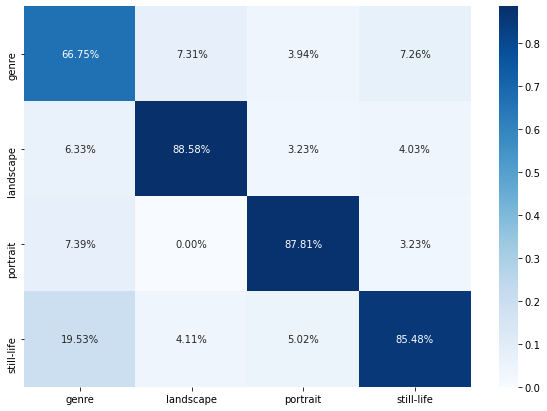

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in artCategories],
                  columns = [i for i in artCategories])
plt.figure(figsize = (10,7))
mx = sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues')
del df_cm

In [16]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model_scratch.state_dict()}

torch.save(checkpoint, pathToModel)

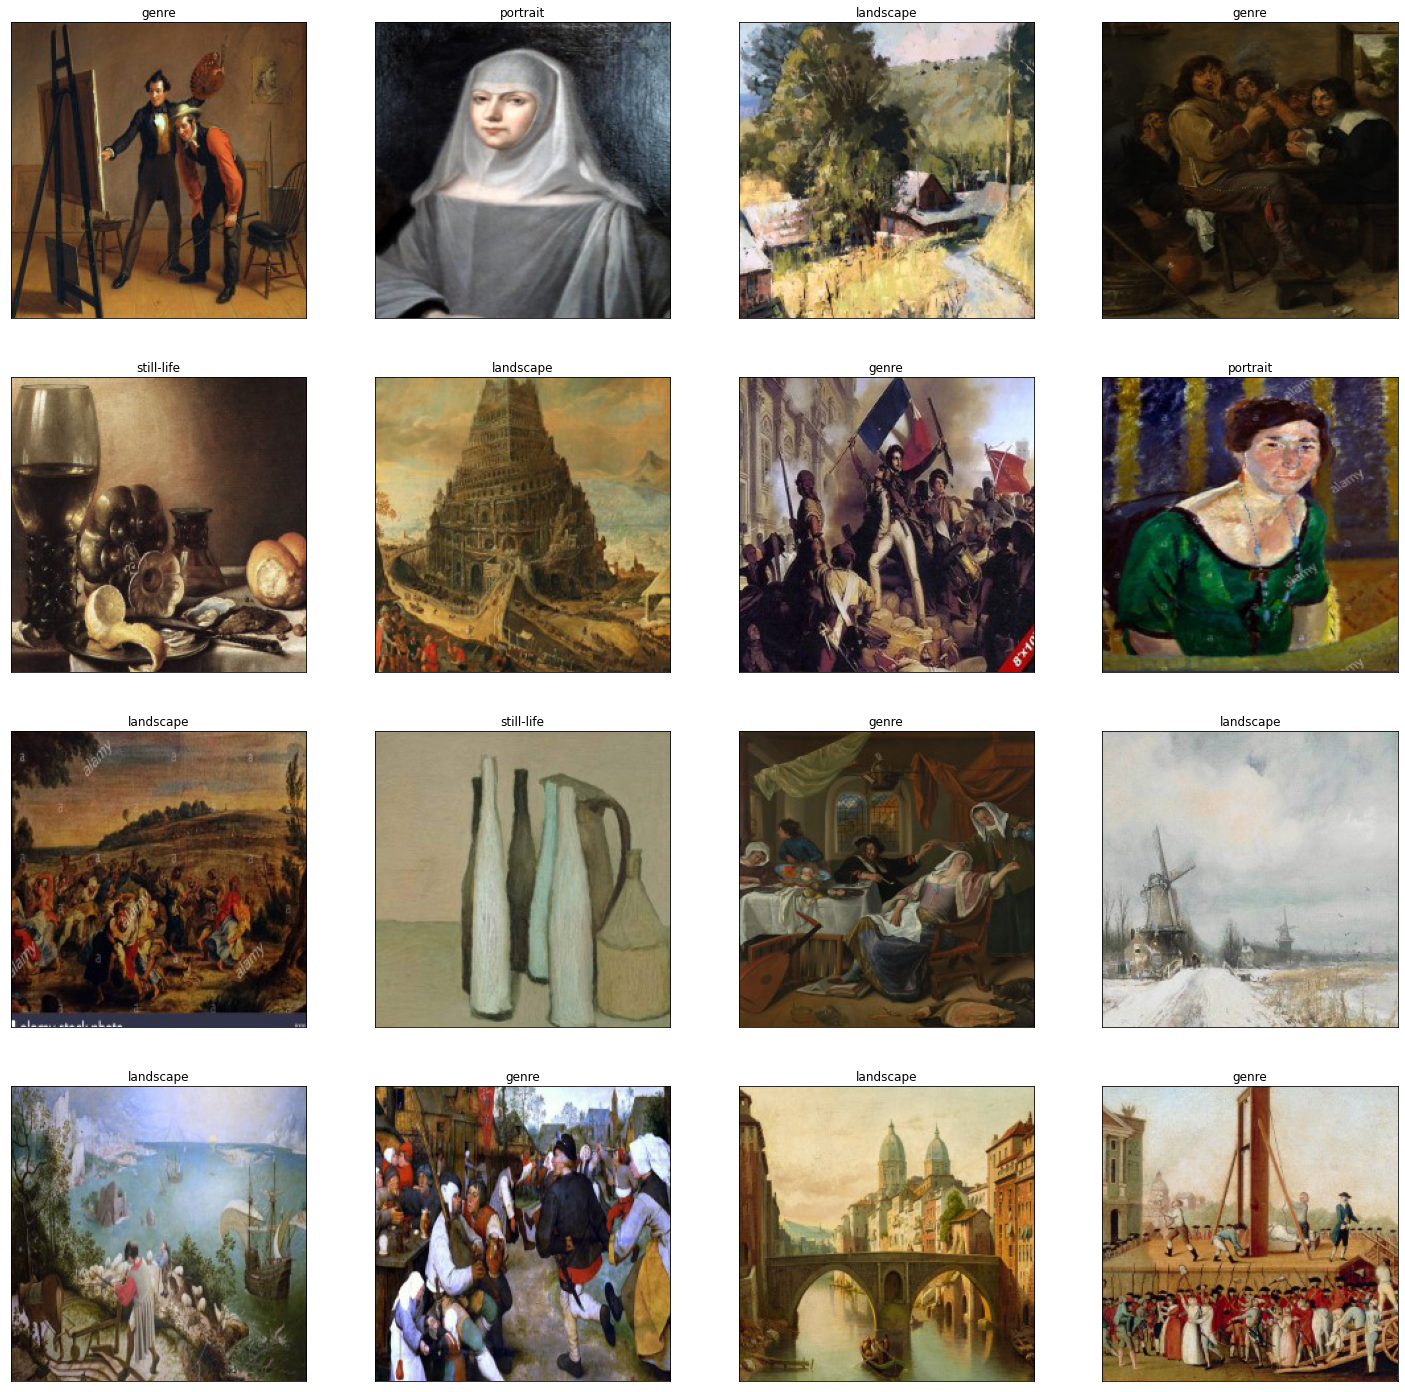

In [19]:
visual_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

visual_dataset = datasets.ImageFolder(pathToTest ,transform=visual_transforms)

# Prepare data loaders
visualization_dataloader = torch.utils.data.DataLoader(visual_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()

# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(artCategories[labels[idx]])

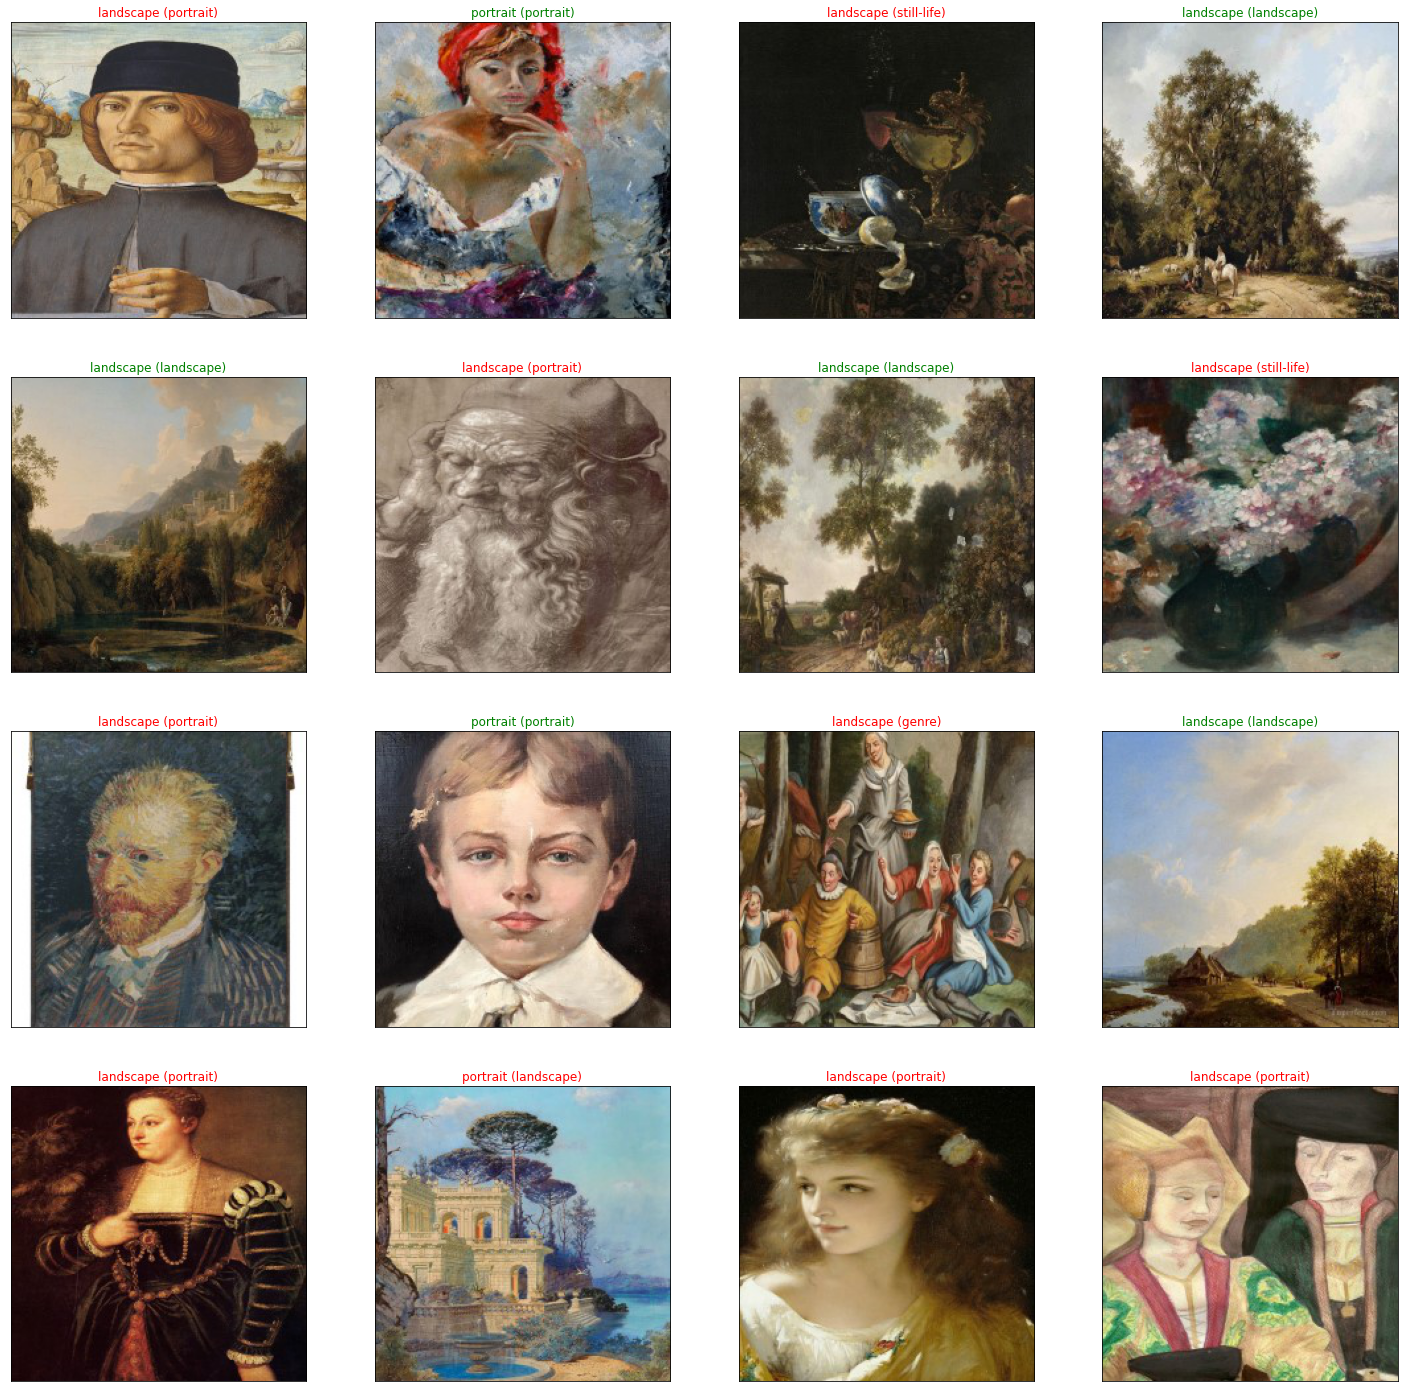

In [22]:
# obtain one batch of test images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:    
    images = images.to(device)
    
# get sample outputs
output = model_scratch(images)

#move images to CPU for plotting
images = images.cpu()

# convert output probabilities to predicted class
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(artCategories[preds[idx]], artCategories[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
